# Linear Regression

### Authors:
 - Benjamín Vega
 - Iuliana Illie

In [3]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor

from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np
from pyspark.ml.tuning import CrossValidator

import matplotlib.pyplot as plt

In [4]:
spark_session = SparkSession\
        .builder\
        .appName("Spark Regression")\
        .getOrCreate()

### Load data in libsvm format

We use libsvm format because spark get better results. The format is: Label, features vector named from 1 to n being n the number of features.

In [5]:
# Load and parse the data file, converting it to a DataFrame.
data = spark_session.read.format("libsvm").load("data/data_file.txt")

In [6]:
data.show()

+----------+--------------------+
|     label|            features|
+----------+--------------------+
|115.970001|(10,[0,1,2,3,4,5,...|
|    116.32|(10,[0,1,2,3,4,5,...|
|118.690002|(10,[0,1,2,3,4,5,...|
|119.029999|(10,[0,1,2,3,4,5,...|
|114.949997|(10,[0,1,2,3,4,5,...|
|110.440002|(10,[0,1,2,3,4,5,...|
|108.769997|(10,[0,1,2,3,4,5,...|
|108.860001|(10,[0,1,2,3,4,5,...|
|    115.32|(10,[0,1,2,3,4,5,...|
|111.199997|(10,[0,1,2,3,4,5,...|
|116.599998|(10,[0,1,2,3,4,5,...|
|115.050003|(10,[0,1,2,3,4,5,...|
|115.040001|(10,[0,1,2,3,4,5,...|
|    115.75|(10,[0,1,2,3,4,5,...|
|116.870003|(10,[0,1,2,3,4,5,...|
|117.510002|(10,[0,1,2,3,4,5,...|
|115.980003|(10,[0,1,2,3,4,5,...|
|119.019997|(10,[0,1,2,3,4,5,...|
|120.709999|(10,[0,1,2,3,4,5,...|
|121.190002|(10,[0,1,2,3,4,5,...|
+----------+--------------------+
only showing top 20 rows



### Split data into train and test sets and normalize 

We indicate 70% for training and 30% for test. `randomSplit` normalizes the data.

In [7]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])
print(trainingData.select("label").show(10))

+--------+
|   label|
+--------+
|0.115513|
|0.116629|
|0.117188|
|0.117188|
|0.117746|
|0.117746|
|0.118304|
|0.118862|
| 0.12221|
| 0.12221|
+--------+
only showing top 10 rows

None


### Training

Creating a model. We have to indicate features and taget (label).

In [8]:
# Train model.
#lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr = LinearRegression(featuresCol = 'features', labelCol = 'label',)

We prepared `ParamGridBuilder`, builder for a param grid used in grid search-based model selection and find the best configuration. we indicate `maxIter`, `regParam` and `elasticNetParam`.

In [9]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [int(x) for x in np.linspace(start = 5, stop = 30, num = 6)]) \
    .addGrid(lr.regParam, [float(x) for x in np.linspace(start = 0.1, stop = 0.9, num = 4)]) \
    .addGrid(lr.elasticNetParam, [float(x) for x in np.linspace(start = 0.01, stop = 1.0, num = 6)]) \
    .build()

Cross Validation, we indicate model, paramGrid and evaluator. To evaluate we need a evaluator with metrics, since we are faced with a regression problem, we use root-mean-square error (rmse) as a metric.

In [10]:
#evaluator for regression, need label, prediction and metric
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

#cross validation
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

We train using cross validaton to fit.

In [11]:
cvModel = crossval.fit(trainingData)

### Evaluation

We have to get predictions from test data.

In [12]:
predictions = cvModel.transform(testData)

In [13]:
predictions.select("prediction", "label", "features").show(10)

+-------------------+--------+--------------------+
|         prediction|   label|            features|
+-------------------+--------+--------------------+
|0.21653024074319616|0.117188|(10,[0,1,2,3,4,5,...|
|0.21173280874186057|0.118862|(10,[0,1,2,3,4,5,...|
|0.21830109234224127|0.123326|(10,[0,1,2,3,4,5,...|
|0.21815775138583063|0.124442|(10,[0,1,2,3,4,5,...|
|0.22054404624469015|0.127232|(10,[0,1,2,3,4,5,...|
|0.23106717442150315|0.136161|(10,[0,1,2,3,4,5,...|
|0.22988346945507582|0.137277|(10,[0,1,2,3,4,5,...|
|0.23673581413316375|0.139509|(10,[0,1,2,3,4,5,...|
|0.24096963180637465|0.142857|(10,[0,1,2,3,4,5,...|
|0.23503935401304915|0.143415|(10,[0,1,2,3,4,5,...|
+-------------------+--------+--------------------+
only showing top 10 rows



We evaluate the predictions and show the results.

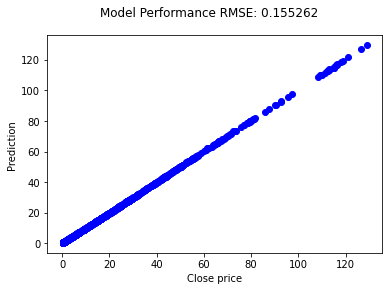

RMSE 0.15526175974146744
           label                                           features  \
0       0.117188  (0.121652, 0.115513, 0.117188, 0.101266, 40635...   
1       0.118862  (0.11942, 0.116071, 0.116629, 0.102713, 107878...   
2       0.123326  (0.127232, 0.122768, 0.124442, 0.106571, 19147...   
3       0.124442  (0.127232, 0.122768, 0.126116, 0.107535, 16589...   
4       0.127232  (0.131696, 0.125, 0.131696, 0.109946, 17118080...   
...          ...                                                ...   
2309  118.275002  (118.392502, 115.732498, 115.75, 118.275002, 1...   
2310  119.029999  (119.620003, 116.870003, 117.949997, 118.82499...   
2311  121.190002  (123.029999, 119.620003, 121.0, 120.981277, 15...   
2312  126.522499  (126.9925, 125.082497, 126.18, 126.522499, 163...   
2313  129.039993  (131.0, 126.0, 127.580002, 129.039993, 2257027...   

      prediction  
0       0.216530  
1       0.211733  
2       0.218301  
3       0.218158  
4       0.220544  
...     

In [14]:
#Evaluate predicctions
rmse = evaluator.evaluate(predictions)

#print results
rfResult = predictions.toPandas()

plt.plot(rfResult.label, rfResult.prediction, 'bo')
plt.xlabel('Close price')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

print("RMSE",rmse)
print(rfResult)

#### Best model and best params

In [15]:
bestModel = cvModel.bestModel

In [16]:
bestModel.getRegParam()

0.1

In [17]:
bestModel.getMaxIter()

25

In [18]:
bestModel.getElasticNetParam()

0.01

#### Best coeficients 

In [19]:
# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(bestModel.coefficients))
print("Intercept: %s" % str(bestModel.intercept))

Coefficients: [0.19997004603931887,0.205398790671028,0.20297608564963734,0.19139144188846233,9.498303262846327e-12,9.498303262846327e-12,0.4667784517865622,0.0,0.20284396466603027,0.0]
Intercept: 0.09363008717669023


#### Best model summarize

In [20]:
# Summarize the model over the training set and print out some metrics
trainingSummary = bestModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

numIterations: 26
objectiveHistory: [0.5, 0.39329328379924317, 0.1007210332607647, 0.0013974774363986332, 0.0009223132620103973, 0.0005760076824828559, 0.00057366121904267, 0.0005730079509826838, 0.0005728775700857092, 0.0005727912824577024, 0.000572163541102485, 0.000572083849036118, 0.0005720287165253454, 0.0005718545880913117, 0.0005718028252191756, 0.000571637126545505, 0.0005715824618997258, 0.0005714427592287779, 0.0005713624768148117, 0.0005712767513699124, 0.0005711772065268555, 0.0005710462426880477, 0.0005710155576838152, 0.0005708523391118939, 0.0005707573875400505, 0.0005707365488915836]
+--------------------+
|           residuals|
+--------------------+
|-0.10009760470555593|
|-0.09579646151824718|
|-0.09303382162185338|
|-0.09586637185342307|
|-0.09735395787857322|
|-0.09945438737740143|
|-0.10017914534419643|
|-0.09389020919571658|
|-0.09441124853056103|
|-0.09406719023384484|
|-0.09346430678895105|
|-0.09272193797783852|
|-0.09443603449441339|
|-0.09636359975424591|
|-